In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from nnAudio.Spectrogram import CQT1992v2
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from functools import partial

In [2]:
import sys
sys.path.insert(0, "../")
from src.models import CustomModel_v1, Andrewnet_v3_true
from src.dataset import TrainDataset
from src.transforms import minmax_bandpass_transform

In [3]:
INPUT_PATH = Path("/home/trytolose/rinat/kaggle/grav_waves_detection/input")

In [4]:
# import torch
# import torch.nn as nn
# import timm

# class CustomModel_v1(nn.Module):
#     def __init__(self, cfg, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model("efficientnet_b0", pretrained=pretrained, in_chans=3, num_classes=1)
#         self.cqt = CQT1992v2(**cfg.qtransform_params)
#         self.h, self.w = 256, 256

#     def forward(self, x):
#         bs, ch, sig_len = x.shape
#         x = x.view(-1, sig_len)
#         x = self.cqt(x).unsqueeze(1)
#         x = nn.functional.interpolate(x, (self.h, self.w))
#         _, _, h, w = x.shape
#         x = x.view(bs, 3, h, w)
#         output = self.model(x)
#         return output


In [5]:
class CFG:
    def __init__(self):
        self.qtransform_params = {
            'sr': 2048,
            'fmin': 20,
            'fmax': 1024,
            'hop_length': 32,
            'bins_per_octave': 8,
        }

        self.bandpass_param = {
          'lf': 30,
          'hf': 400,
          'order': 8, 
          'sr': 2048,
        }
cfg = CFG()

In [6]:
df = pd.read_csv(INPUT_PATH / "sample_submission.csv")

files = list((INPUT_PATH / "test").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])

In [7]:
# model = CustomModel_v1(encoder='rexnet_150', img_h=512, img_w=512,).cuda()
# # model = Andrewnet_v3_true().cuda()
# transform_f = partial(minmax_bandpass_transform, params=cfg.bandpass_param)
# val_ds = TrainDataset(
#     df,
#     mode="test",
#     transform=transform_f,
# )
# val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=64, pin_memory=False)
# total_predicts = []
# for f in range(1):
#     model.load_state_dict(torch.load(f"../weights/CustomModel_v1/011_rexnet150_bandpass_fp16_cos_5_radam_512_2021-08-30-09-11-44/fold_0/cp_epoch03_score0.87290.pth"))
# #     model.load_state_dict(torch.load(f"/home/trytolose/rinat/kaggle/grav_waves_detection/weights/Wavenet/010_wavenet_bandpass_fp32_cos_10_2021-08-30-05-38-05/fold_0/cp_epoch08_score0.86815.pth"))
#     val_pred = []
#     model.eval()
#     with torch.no_grad():
#         for x in tqdm(val_loader, ncols=50, leave=True):
#             x = x.cuda().float()
#             pred = model(x)
#             pred = pred.sigmoid().cpu().data.numpy()
#             val_pred.append(pred)
            
#     val_pred = np.concatenate(val_pred).reshape(-1,)
#     total_predicts.append(val_pred)

CQT kernels created, time used = 0.0061 seconds


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)
100%|█████████| 3532/3532 [12:12<00:00,  4.82it/s]


In [8]:
paths = [
    "../weights/Wavenet/010_wavenet_bandpass_fp32_cos_10_2021-08-30-05-38-05/fold_0/cp_epoch08_score0.86815.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_1/cp_epoch11_score0.86439.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_2/cp_epoch11_score0.86913.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_3/cp_epoch10_score0.86845.pth",
    "../weights/Wavenet/028_wavenet_bandpass_fp32_cos_10_best.yaml/fold_4/cp_epoch10_score0.86553.pth",
]

In [9]:
# model = CustomModel_v1().cuda()
model = Andrewnet_v3_true().cuda()
transform_f = partial(minmax_bandpass_transform)

val_ds = TrainDataset(
    df,
    mode="test",
    transform=transform_f,
)
val_loader = DataLoader(val_ds, shuffle=False, num_workers=12, batch_size=64, pin_memory=False)
total_predicts = []

for w_path in paths:
    model.load_state_dict(torch.load(w_path))
    val_pred = []
    model.eval()
    with torch.no_grad():
        for x in tqdm(val_loader, ncols=50, leave=True):
            x = x.cuda().float()
            pred = model(x)
            pred = pred.sigmoid().cpu().data.numpy()
            val_pred.append(pred)
            
    val_pred = np.concatenate(val_pred).reshape(-1,)
    total_predicts.append(val_pred)

100%|█████████| 3532/3532 [03:48<00:00, 15.48it/s]


In [10]:
total_predicts = np.stack(total_predicts)

In [11]:
total_predicts.shape

(5, 226000)

In [12]:
df['target'] = total_predicts.mean(axis=0)

In [13]:
df = df.drop("path", axis=1)

In [14]:
df

,id,target
0,00005bced6,0.999924
1,0000806717,0.988476
2,0000ef4fe1,0.241230
3,00020de251,0.537449
4,00024887b5,0.166916
...,...,...
225995,ffff4125f1,0.351886
225996,ffff9d32a6,0.355625
225997,ffff9f4c1f,0.239442
225998,ffffa19693,0.999924


In [15]:
df.to_csv("submission_wavenet_01234.csv", index=False)

In [113]:
df_rex = pd.read_csv("submission_rexnet150.csv")

In [114]:
df_blend = df.copy()

In [115]:
df_blend['target'] = 0.5* df['target'] + 0.5*df_rex['target']
df_blend.to_csv("submission_blend.csv", index=False)

In [16]:
!kaggle competitions submit -c g2net-gravitational-wave-detection -f submission_wavenet_01234.csv -m "submission_wavenet_01234"

100%|██████████████████████████████████████| 4.66M/4.66M [00:03<00:00, 1.33MB/s]
Successfully submitted to G2Net Gravitational Wave Detection

In [ ]:
df_top_fp=df[df['target']==0].sort_values("target_pred", ascending=False)[:10]
df_top_fp.to_csv("top_10_fp.csv", index=False)

In [ ]:
df_min = df.sort_values("target_pred")[:10].copy()
df_max = df.sort_values("target_pred", ascending=False)[:10].copy()

In [ ]:
df_max

In [ ]:
df_total = pd.concat([df_max, df_min], ignore_index=True)
df_total.to_csv("top_min_max.csv", index=False)

In [ ]:
!nvidia-smi

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [36]:
from torch.optim import Adam
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR
import matplotlib.pyplot as plt
from timm.scheduler import CosineLRScheduler

model = models.resnet18()
optimizer = Adam(model.parameters(), lr=0.001)

In [69]:
lrs = []
scheduler = CosineLRScheduler(optimizer, 30, t_mul=1, warmup_t=15, cycle_limit=1)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
# scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
# print(scheduler.T_max)
lrs.append(get_lr(optimizer))
for epoch in range(200):
#     for i in range(3500):
    optimizer.step()
#         if epoch < 5:
#         scheduler.step(epoch + i / 3500)
    lrs.append(get_lr(optimizer))
    scheduler.step(epoch)

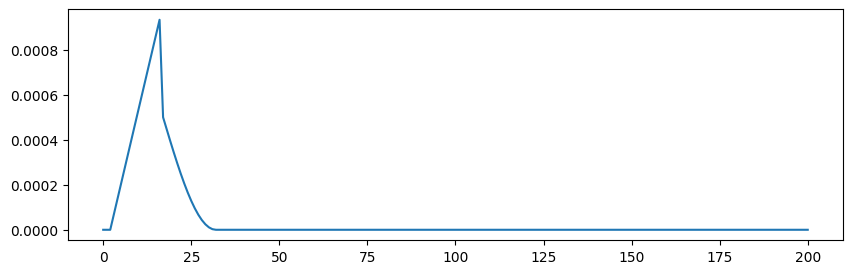

In [70]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()

In [96]:
lrs = []
scheduler = CosineLRScheduler(optimizer, t_initial=7, t_mul=3, warmup_t=1, cycle_limit=1, decay_rate=0.0001)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 5, 1)
# scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
# print(scheduler.T_max)
lrs.append(get_lr(optimizer))
for epoch in range(10):
    for i in range(3500):
        optimizer.step()
#         if epoch < 5:
        scheduler.step(epoch + i / 3500)
        lrs.append(get_lr(optimizer))
        scheduler.step(epoch)

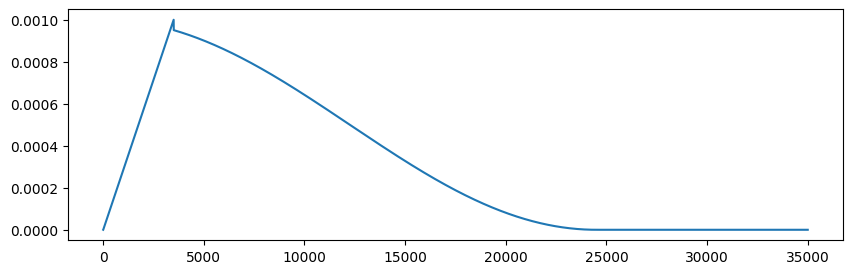

In [97]:
plt.figure(figsize=(10,3))
plt.plot(lrs)
plt.show()

In [16]:
X_std = (x - np.array([0, 0, 0])) / 10
X_scaled = X_std * (2) - 1

In [17]:
X_scaled

array([[[ 0.2,  0.4, -0.2],
        [ 0.2,  0. , -0.8],
        [-0.4,  0. , -0.6],
        [-0.8, -0.8,  0.8],
        [ 0.4, -0.4, -0.2],
        [-0.6, -0.6, -0.8],
        [-0.2, -0.4, -0.4],
        [ 0.8, -0.6,  0. ],
        [-0.4,  0. ,  0.4]],

       [[ 0.4, -0.4, -0.6],
        [-0.6, -0.2, -1. ],
        [ 0.8, -1. , -1. ],
        [-0.8, -0.6, -0.8],
        [-1. , -0.2,  0.4],
        [ 0. , -1. ,  0.6],
        [ 0.2,  0.2, -0.2],
        [ 0.4,  0.4,  0.8],
        [-0.8,  0.6, -1. ]],

       [[-0.2,  0. ,  0.2],
        [-0.8, -1. , -0.4],
        [-0.8,  0.2,  0.8],
        [ 0.4, -0.4, -0.8],
        [ 0.2,  0.8,  0.2],
        [-0.8,  0.8, -0.6],
        [-0.4, -0.2, -0.6],
        [ 0.8,  0.8, -0.8],
        [-0.4,  0.6,  0.8]],

       [[ 0.6, -0.8,  0. ],
        [-0.8,  0.4, -0.8],
        [ 0.8, -0.8,  0.8],
        [ 0.6,  0.4, -0.6],
        [ 0.6, -0.4, -0.4],
        [-0.8,  0.6, -0.8],
        [-0.6, -0.4,  0.4],
        [-0.2,  0. , -0.8],
        [-0.2,